In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as sp
import itertools
import time

# Generation of Microstructure

In [2]:
def create_bin_circle(matrix_size, center, radius):
    x = tf.cast(tf.linspace(0, matrix_size - 1, matrix_size), dtype=tf.float32)
    y = tf.cast(tf.linspace(0, matrix_size - 1, matrix_size), dtype=tf.float32)
    center = tf.cast(center, dtype=tf.float32)
    coords = tf.meshgrid(x, y)
    distance = tf.sqrt((coords[0] - center[0]) ** 2
                      +(coords[1] - center[1]) ** 2)
    return tf.cast(distance <= radius, tf.int32)

In [3]:
def circle(inclusion_fraction, image_size, radius):
    """Create circular inclusion.
    Generate random circular inclusion in a two dimensional unit cell.
    Args:
        - inclusion_fraction: The volume fraction of the inclusion phase.
        - no_of_voxels: Dimensions of the unit cell.

    Returns:
        microstructure: Voxelized microstructure with circular inclusion.
    """
    no_of_voxels = image_size
    microstructure = tf.zeros(
        shape=(no_of_voxels, no_of_voxels), dtype=tf.int32
    )

    no_of_spheres = 0
    real_cf = None
    while (
            tf.size(microstructure[microstructure == 1])
            / tf.size(microstructure) <= inclusion_fraction
    ):
        r = radius
        sphere_center = tf.random.uniform(
            minval=0,
            maxval=no_of_voxels - 1,
            shape=(2, 1),
            dtype=tf.int32,
        )
        sphere = create_bin_circle(no_of_voxels, sphere_center, r)
        if tf.reduce_any(tf.cast(microstructure[sphere == 1], tf.bool)):
          # print("overlap")
          pass

        else:

            microstructure = tf.where(condition=tf.equal(sphere, 1),
                                      x=1, y=microstructure)
            no_of_spheres += 1
            real_cf = tf.convert_to_tensor([tf.size(microstructure[microstructure == 1])/ tf.size(microstructure)],
                                           dtype=tf.float32)

    microstructure = tf.reshape(microstructure,
                                shape=(no_of_voxels, no_of_voxels, 1))
    real_cf = tf.reshape(real_cf, shape=(1,))
    microstructure = tf.cast(x=microstructure, dtype=tf.float32)
    return {"microstructure": microstructure, "volume_fraction": real_cf}

In [4]:
INCLUSION_FRACTION = 0.2
IMG_SIZE = 128
RADIUS = 8
NO_OF_SAMPLES = 1
microstructure = []
for i in range(NO_OF_SAMPLES):
  microstructure.append(circle(inclusion_fraction=INCLUSION_FRACTION, image_size=IMG_SIZE, radius=RADIUS).get("microstructure"))

In [5]:
micro = tf.convert_to_tensor(microstructure)

In [6]:
extended_micro = tf.expand_dims(microstructure, -1)
extended_micro.shape

TensorShape([1, 128, 128, 1, 1])

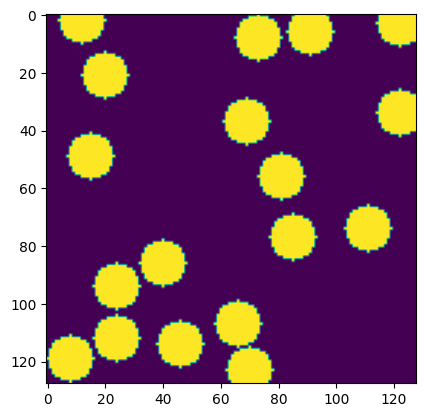

In [7]:
for i in range(1):
    plt.figure(i)
    plt.imshow(tf.reshape(extended_micro[i, :, :, :, :], [IMG_SIZE,IMG_SIZE]))

In [8]:
extended_micro.shape

TensorShape([1, 128, 128, 1, 1])

# Autoencoder for Model Order Reduction

In [13]:
FILTERS=30
KERNEL_SIZE=5
encoder = tf.keras.Sequential(name='Encoder')
# encoder.add(tf.keras.layers.Conv2D(filters=FILTERS, 
#                                  kernel_size=KERNEL_SIZE, 
#                                  strides=1, 
#                                  padding='same',
#                                  activation='relu'))
# encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
#                                        padding='same',
#                                        data_format='channels_last'))
# encoder.add(tf.keras.layers.Conv2D(filters=2*FILTERS, 
#                                  kernel_size=KERNEL_SIZE, 
#                                  strides=1, 
#                                  padding='same',
#                                  activation='relu'))
# encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
#                                        padding='same',
#                                        data_format='channels_last'))
# encoder.add(tf.keras.layers.Conv2D(filters=4*FILTERS, 
#                                  kernel_size=KERNEL_SIZE, 
#                                  strides=1, 
#                                  padding='same',
#                                  activation='relu'))
# encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
#                                        padding='same',
#                                        data_format='channels_last'))
# encoder.add(tf.keras.layers.Conv2D(filters=8*FILTERS, 
#                                  kernel_size=KERNEL_SIZE, 
#                                  strides=1, 
#                                  padding='same',
#                                  activation='relu'))
# encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
#                                        padding='same',
#                                        data_format='channels_last'))
# encoder.add(tf.keras.layers.Conv2D(filters=8*FILTERS, 
#                                  kernel_size=KERNEL_SIZE, 
#                                  strides=1, 
#                                  padding='same',
#                                  activation='relu'))
# encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
#                                        padding='same',
#                                        data_format='channels_last'))


# padding valid .......

encoder.add(tf.keras.layers.Conv2D(filters=FILTERS, 
                                 kernel_size=3, 
                                 strides=1, 
                                 padding='same',
                                 activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5),
                                       strides=1,
                                       padding='valid',
                                       data_format='channels_last'))
# encoder.add(tf.keras.layers.Conv2D(filters=FILTERS, 
#                                  kernel_size=3, 
#                                  strides=1, 
#                                  padding='same',
#                                  activation='relu'))
# encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5),
#                                        strides=1,
#                                        padding='valid',
#                                        data_format='channels_last'))


decoder = tf.keras.Sequential(name='Decoder')
# decoder.add(tf.keras.layers.Conv2DTranspose(filters=FILTERS,
#                                           kernel_size=5,
#                                           strides=1,
#                                           activation='relu',
#                                           padding='valid'))
decoder.add(tf.keras.layers.Conv2DTranspose(filters=FILTERS,
                                          kernel_size=5,
                                          strides=1,
                                          activation='relu',
                                          padding='valid'))

# padding valid ..... 

# decoder.add(tf.keras.layers.Conv2DTranspose(filters=8*FILTERS,
#                                           kernel_size=KERNEL_SIZE,
#                                           strides=2,
#                                           activation='relu',
#                                           padding='same'))
# decoder.add(tf.keras.layers.Conv2DTranspose(filters=8*FILTERS,
#                                           kernel_size=KERNEL_SIZE,
#                                           strides=2,
#                                           activation='relu',
#                                           padding='same'))
# decoder.add(tf.keras.layers.Conv2DTranspose(filters=4*FILTERS,
#                                           kernel_size=KERNEL_SIZE,
#                                           strides=2,
#                                           activation='relu',
#                                           padding='same'))
# decoder.add(tf.keras.layers.Conv2DTranspose(filters=2*FILTERS,
#                                           kernel_size=KERNEL_SIZE,
#                                           strides=2,
#                                           activation='relu',
#                                           padding='same'))
# decoder.add(tf.keras.layers.Conv2DTranspose(filters=FILTERS,
#                                           kernel_size=KERNEL_SIZE,
#                                           strides=2,
#                                           activation='relu',
#                                           padding='same'))
decoder.add(tf.keras.layers.Conv2D(filters=1, 
                                 kernel_size=KERNEL_SIZE, 
                                 strides=1, 
                                 padding='same',
                                 activation='sigmoid'))

model = tf.keras.Sequential([encoder,
                             decoder],
                            name='Autoencoder')
model.compile(optimizer='adam', loss='mse')
model.build(input_shape = (None,IMG_SIZE,IMG_SIZE,1))

In [14]:
encoder.summary()
decoder.summary()
model.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 30)      300       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 125, 125, 30)     0         
 2D)                                                             
                                                                 
Total params: 300
Trainable params: 300
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 30)     14430     
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128

# Training

In [26]:
history = model.fit(micro, micro, batch_size= NO_OF_SAMPLES, epochs=600)

Epoch 1/600
1/1 [==============================] - 1s 1s/step - loss: 0.2493
Epoch 2/600
1/1 [==============================] - 0s 10ms/step - loss: 0.2451
Epoch 3/600
1/1 [==============================] - 0s 9ms/step - loss: 0.2410
Epoch 4/600
1/1 [==============================] - 0s 9ms/step - loss: 0.2369
Epoch 5/600
1/1 [==============================] - 0s 10ms/step - loss: 0.2326
Epoch 6/600
1/1 [==============================] - 0s 12ms/step - loss: 0.2281
Epoch 7/600
1/1 [==============================] - 0s 11ms/step - loss: 0.2235
Epoch 8/600
1/1 [==============================] - 0s 8ms/step - loss: 0.2188
Epoch 9/600
1/1 [==============================] - 0s 12ms/step - loss: 0.2142
Epoch 10/600
1/1 [==============================] - 0s 9ms/step - loss: 0.2093
Epoch 11/600
1/1 [==============================] - 0s 11ms/step - loss: 0.2040
Epoch 12/600
1/1 [==============================] - 0s 9ms/step - loss: 0.1979
Epoch 13/600
1/1 [==============================] - 0s 1

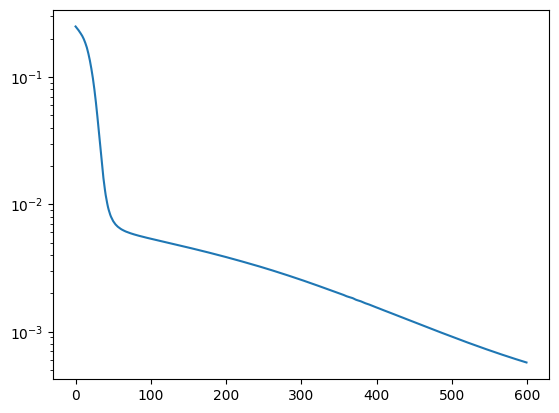

In [27]:
plt.semilogy(history.history["loss"])

In [28]:
model.evaluate(x=micro, y=micro)

1/1 [==============================] - 0s 151ms/step - loss: 5.6883e-04


0.0005688312230631709

In [29]:
predicted = model.predict(x=extended_micro, batch_size=1)

1/1 [==============================] - 0s 102ms/step


In [30]:
# predicted_filtered = predicted
# predicted_filtered[predicted>0.5] = 1.0
# predicted_filtered[predicted<=0.5] = 0.0 

In [31]:
encoded_image = encoder.predict(x=micro, batch_size=1)
enc_shape = encoded_image.shape[1]

1/1 [==============================] - 0s 61ms/step


In [32]:
encoded_image.shape

(1, 64, 64, 30)

# Compare Original, Encoded and Predicted Microstructure image

In [33]:
predicted_img_sample = tf.slice(predicted,
                                begin=[0, 0, 0, 0],
                                size=[1, IMG_SIZE, IMG_SIZE, 1])

encoded_img_sample = tf.slice(encoded_image,
                                begin=[0, 0, 0, 2],
                                size=[1, enc_shape, enc_shape, 1])

original_img_sample = tf.slice(micro,
                               begin=[0, 0, 0, 0],
                               size=[1, IMG_SIZE, IMG_SIZE, 1])

In [34]:
micro_img = tf.reshape(original_img_sample, [IMG_SIZE,IMG_SIZE])
predicted_micro_img = tf.reshape(predicted_img_sample, [IMG_SIZE,IMG_SIZE])
encoded_micro_img = tf.reshape(encoded_img_sample, [enc_shape, enc_shape])

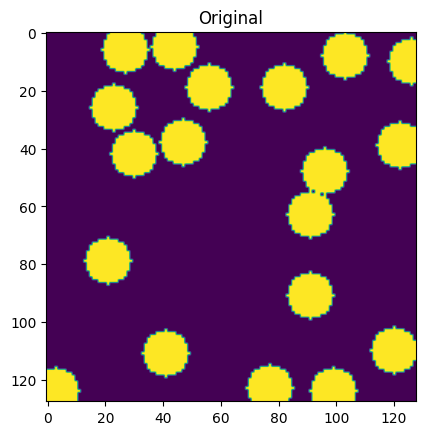

In [37]:
plt.title("Original")
plt.imshow(micro_img)

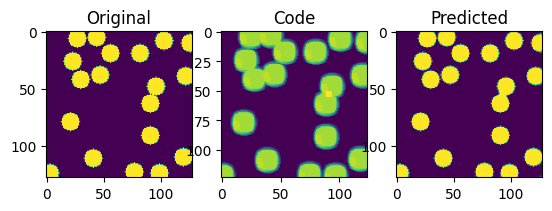

In [20]:
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(micro_img)

plt.subplot(1,3,2)
plt.title("Code")
plt.imshow(encoded_micro_img)

plt.subplot(1,3,3)
plt.title("Predicted")
plt.imshow(predicted_micro_img)

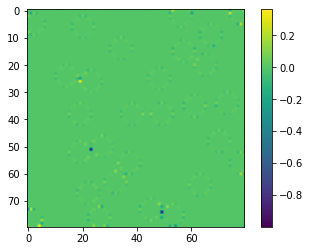

In [ ]:
#Reconstruction error
error = micro_img - predicted_micro_img
plt.imshow(error)
plt.colorbar()

In [ ]:
print(tf.norm(error)/tf.norm(micro_img))

tf.Tensor(0.05644953, shape=(), dtype=float32)


In [ ]:
encoded_image = tf.math.reduce_mean(encoded_image, axis=-1)

In [ ]:
encoded_image.shape

TensorShape([10, 40, 40])

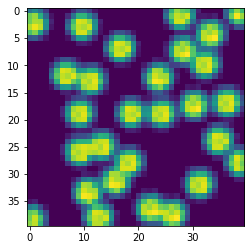

In [ ]:
plt.imshow(tf.reshape(encoded_image[0, :, :],[enc_shape,enc_shape]))

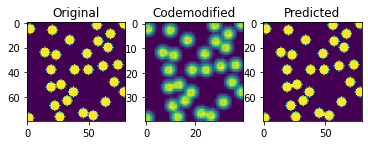

In [ ]:
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(micro_img)

plt.subplot(1,3,2)
plt.title("Codemodified")
plt.imshow(tf.reshape(encoded_image[0, :, :],[enc_shape,enc_shape]))

plt.subplot(1,3,3)
plt.title("Predicted")
plt.imshow(predicted_micro_img)

In [ ]:
def conv(img):
  original_sample = tf.slice(img,
                               begin=[0, 0, 0],
                               size=[1, img.shape[1]-1, img.shape[1]-1])
  original_sample.shape[1]
  code_img = tf.reshape(original_sample, [original_sample.shape[1], original_sample.shape[1]])
  # exp_img = tf.expand_dims(code_img, -1)
  # exp_img = exp_img.numpy()
  exp_img = code_img.numpy()
  return exp_img

In [ ]:
def conv_org(img):
  original_sample = tf.slice(img,
                               begin=[0, 0, 0, 0],
                               size=[1, img.shape[1]-1, img.shape[1]-1, 1])
  original_sample.shape[1]
  code_img = tf.reshape(original_sample, [original_sample.shape[1], original_sample.shape[1]])
  exp_img = tf.expand_dims(code_img, -1)
  exp_img = exp_img.numpy()
  return exp_img

In [ ]:
exp_code_img = conv(encoded_image)
exp_original_img = conv_org(micro)

In [ ]:
# exp_code_img[exp_code_img > 0.5] = 1
# exp_code_img[exp_code_img <= 0.5] = 0

In [ ]:
exp_code_img = np.expand_dims(exp_code_img, axis=-1)

In [ ]:
exp_code_img.shape

(39, 39, 1)

# Plotting Stress Field

In [ ]:
"""2D homogenization using double precision in one direction."""

def stress(img):
  t0 = time.time()


  def is_odd(num):
      return num & 0x1


  # ----------------------------------- Microstructure --------------------------
  # Define microstructure
  microstructure = img
  voxel_length = microstructure.shape[0]
  # center = microstructure.shape[0] // 2
  # radius = voxel_length // 10

  # for i in range(voxel_length):
  #     for j in range(voxel_length):
  #         in_circle = (i - center) ** 2 + (j - center) ** 2 <= radius**2
  #         if in_circle:
  #             microstructure[i, j, 0] = 1.0


  # ----------------------------------- GRID ------------------------------------
  Nx = voxel_length  # number of voxels in x-direction
  Ny = voxel_length  # number of voxels in y-direction
  Nz = 2  # number of voxels in z-direction
  shape = [Nx, Ny, Nz]  # number of voxels as list: [Nx,Ny,Nz]
  ndof = 3**2 * Nx * Ny * Nz  # number of degrees-of-freedom
  odd = bool(is_odd(voxel_length))

  # ---------------------- PROJECTION, TENSORS, OPERATIONS ----------------------

  # tensor operations/products: np.einsum enables index notation, avoiding loops
  # e.g. ddot42 performs $C_ij = A_ijkl B_lk$ for the entire grid
  trans2 = lambda A2: np.einsum("ijxyz          ->jixyz  ", A2)
  ddot22 = lambda A2, B2: np.einsum("ijxyz  ,jixyz  ->xyz    ", A2, B2)
  ddot42 = lambda A4, B2: np.einsum("ijklxyz,lkxyz  ->ijxyz  ", A4, B2)
  ddot44 = lambda A4, B4: np.einsum("ijklxyz,lkmnxyz->ijmnxyz", A4, B4)
  dot11 = lambda A1, B1: np.einsum("ixyz   ,ixyz   ->xyz    ", A1, B1)
  dot22 = lambda A2, B2: np.einsum("ijxyz  ,jkxyz  ->ikxyz  ", A2, B2)
  dot24 = lambda A2, B4: np.einsum("ijxyz  ,jkmnxyz->ikmnxyz", A2, B4)
  dot42 = lambda A4, B2: np.einsum("ijklxyz,lmxyz  ->ijkmxyz", A4, B2)
  dyad22 = lambda A2, B2: np.einsum("ijxyz  ,klxyz  ->ijklxyz", A2, B2)

  # identity tensor [single tensor]
  i = np.eye(3)
  # identity tensors [grid of tensors]
  I = np.einsum("ij,xyz", i, np.ones([Nx, Ny, Nz]))
  I4 = np.einsum(
      "ijkl,xyz->ijklxyz", np.einsum("il,jk", i, i), np.ones([Nx, Ny, Nz])
  )
  I4rt = np.einsum(
      "ijkl,xyz->ijklxyz", np.einsum("ik,jl", i, i), np.ones([Nx, Ny, Nz])
  )
  II = dyad22(I, I)
  I4s = (I4 + I4rt) / 2.0
  I4d = I4s - II / 3.0

  # projection operator (zero for zero frequency, associated with the mean)
  # NB: vectorized version of "../linear-elasticity.py"
  # - allocate / define support function
  if not odd:
      raise NotImplementedError(
          "The dimensions of the microstructure have to " "be odd!"
      )

  else:
      # projection operator (only for non-zero frequency,
      # associated with the mean)
      # - allocate / support function
      Ghat4 = np.zeros([3, 3, 3, 3, Nx, Ny, Nz])  # projection operator
      x = np.zeros([3, Nx, Ny, Nz], dtype="int64")  # position vectors
      q = np.zeros([3, Nx, Ny, Nz], dtype="int64")  # frequency vectors
      delta = lambda i, j: float(i == j)  # Dirac delta function
      # - set "x" as position vector of all grid-points
      # [grid of vector-components]
      x[0], x[1], x[2] = np.mgrid[:Nx, :Ny, :Nz]
      # - convert positions "x" to frequencies "q"
      # [grid of vector-components]
      for i in range(3):
          freq = np.arange(
              -(shape[i] - 1) / 2, +(shape[i] + 1) / 2, dtype="int64"
          )
          q[i] = freq[x[i]]
      # - compute "Q = ||q||", and "norm = 1/Q" being zero for the mean (Q==0)
      #   NB: avoid zero division
      q = q.astype(float)
      Q = dot11(q, q)
      Z = Q == 0
      Q[Z] = 1.0
      norm = 1.0 / Q
      norm[Z] = 0.0
      # - set projection operator [grid of tensors]
      for i, j, l, m in itertools.product(range(3), repeat=4):
          Ghat4[i, j, l, m] = norm * delta(i, m) * q[j] * q[l]


  # (inverse) Fourier transform (for each tensor component in each direction)
  fft = lambda x: np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x), [Nx, Ny, Nz]))
  ifft = lambda x: np.fft.fftshift(
      np.fft.ifftn(np.fft.ifftshift(x), [Nx, Ny, Nz])
  )

  # functions for the projection 'G', and the product 'G : K : eps'
  G = lambda A2: np.real(ifft(ddot42(Ghat4, fft(A2)))).reshape(-1)
  K_deps = lambda depsm: ddot42(K4, depsm.reshape(3, 3, Nx, Ny, Nz))
  G_K_deps = lambda depsm: G(K_deps(depsm))

  # ------------------- PROBLEM DEFINITION / CONSTITIVE MODEL -------------------

  # constitutive response to a certain loading
  # NB: completely uncoupled from the FFT-solver, but implemented as a regular
  #     grid of quadrature points, to have an efficient code;
  #     each point is completely independent, just evaluated at the same time
  # NB: all points for both models, but selectively ignored per materials
  #     this avoids loops or a problem specific constitutive implementation

  # linear elasticity
  # -----------------


  def elastic(eps, phase):

      # parameters
      if phase == 0:
          K = 2.0  # bulk  modulus
          mu = 1.0  # shear modulus
      elif phase == 1:
          K = 20.0  # bulk  modulus
          mu = 10.0  # shear modulus
      else:
          raise NotImplementedError("Phases should be either '0', or '1'!")

      # elastic stiffness tensor, and stress response
      C4 = K * II + 2.0 * mu * I4d
      sig = ddot42(C4, eps)

      return sig, C4


  def constitutive(eps, phases):
      phase = phases

      sig_P1, K4_P1 = elastic(eps=eps, phase=0)
      sig_P2, K4_P2 = elastic(eps=eps, phase=1)

      sig = phase * sig_P1 + (1.0 - phase) * sig_P2
      K4 = phase * K4_P1 + (1.0 - phase) * K4_P2

      return sig, K4


  # ----------------------------- NEWTON ITERATIONS -----------------------------
  # initialize: strain and stress/tangent
  eps = np.zeros([3, 3, Nx, Ny, Nz])
  sig, K4 = constitutive(eps=eps, phases=microstructure)

  # set macroscopic loading
  DE = np.zeros([3, 3, Nx, Ny, Nz])
  DE[0, 0] += 1.0

  # initial residual: distribute "DE" over grid using "K4"
  b = -G_K_deps(DE)
  eps += DE

  # compute DOF-normalization, set Newton iteration counter
  En = np.linalg.norm(eps)
  iiter = 0

  # iterate as long as the iterative update does not vanish
  while True:

      # solve linear system using the Conjugate Gradient iterative solver
      depsm, _ = sp.cg(
          tol=1.0e-8,
          A=sp.LinearOperator(
              shape=(ndof, ndof), matvec=G_K_deps, dtype="float"
          ),
          b=b,
      )

      # add solution of linear system to DOFs
      eps += depsm.reshape(3, 3, Nx, Ny, Nz)

      # new residual
      sig, K4 = constitutive(eps, phases=microstructure)
      b = -G(sig)
      # check for convergence
      # print("{0:10.2e}".format(np.linalg.norm(depsm) / En))
      if np.linalg.norm(depsm) / En < 1.0e-8 and iiter > 0:
          break

      # update Newton iteration counter
      iiter += 1

  t1 = time.time()

  total_time = t1 - t0


  print(f"\nC11: {np.mean(sig, axis=(2, 3, 4))[0, 0]}")
  print(f"\nsigma: \n{np.round(np.mean(sig, axis=(2, 3, 4)), 4)}")
  print(f"\ntime: {total_time}")

  x = np.squeeze(microstructure, axis=2)

  plt.subplot(211)
  # plt.imshow(x, cmap="hot")
  plt.imshow(x)
  plt.colorbar()
  plt.title("Microstructure")
  plt.gca().set_aspect("equal")

  plt.subplot(212)
  xlist = np.linspace(0, Nx, Nx)
  ylist = np.linspace(0, Ny, Ny)
  X, Y = np.meshgrid(xlist, ylist)
  X = np.flipud(X)
  Y = np.flipud(Y)
  Z = sig[0, 0, :, :, 0]

  # plt.contourf(X, Y, Z, cmap="hot")
  plt.contourf(X, Y, Z)
  plt.colorbar()
  plt.title("11-Stress component")
  plt.gca().set_aspect("equal")

  plt.show()


In [ ]:
t0 = time.time()


def is_odd(num):
    return num & 0x1


# ----------------------------------- Microstructure --------------------------
# Define microstructure
microstructure = exp_original_img
voxel_length = microstructure.shape[0]
# center = microstructure.shape[0] // 2
# radius = voxel_length // 10

# for i in range(voxel_length):
#     for j in range(voxel_length):
#         in_circle = (i - center) ** 2 + (j - center) ** 2 <= radius**2
#         if in_circle:
#             microstructure[i, j, 0] = 1.0


# ----------------------------------- GRID ------------------------------------
Nx = voxel_length  # number of voxels in x-direction
Ny = voxel_length  # number of voxels in y-direction
Nz = 2  # number of voxels in z-direction
shape = [Nx, Ny, Nz]  # number of voxels as list: [Nx,Ny,Nz]
ndof = 3**2 * Nx * Ny * Nz  # number of degrees-of-freedom
odd = bool(is_odd(voxel_length))

# ---------------------- PROJECTION, TENSORS, OPERATIONS ----------------------

# tensor operations/products: np.einsum enables index notation, avoiding loops
# e.g. ddot42 performs $C_ij = A_ijkl B_lk$ for the entire grid
trans2 = lambda A2: np.einsum("ijxyz          ->jixyz  ", A2)
ddot22 = lambda A2, B2: np.einsum("ijxyz  ,jixyz  ->xyz    ", A2, B2)
ddot42 = lambda A4, B2: np.einsum("ijklxyz,lkxyz  ->ijxyz  ", A4, B2)
ddot44 = lambda A4, B4: np.einsum("ijklxyz,lkmnxyz->ijmnxyz", A4, B4)
dot11 = lambda A1, B1: np.einsum("ixyz   ,ixyz   ->xyz    ", A1, B1)
dot22 = lambda A2, B2: np.einsum("ijxyz  ,jkxyz  ->ikxyz  ", A2, B2)
dot24 = lambda A2, B4: np.einsum("ijxyz  ,jkmnxyz->ikmnxyz", A2, B4)
dot42 = lambda A4, B2: np.einsum("ijklxyz,lmxyz  ->ijkmxyz", A4, B2)
dyad22 = lambda A2, B2: np.einsum("ijxyz  ,klxyz  ->ijklxyz", A2, B2)

# identity tensor [single tensor]
i = np.eye(3)
# identity tensors [grid of tensors]
I = np.einsum("ij,xyz", i, np.ones([Nx, Ny, Nz]))
I4 = np.einsum(
    "ijkl,xyz->ijklxyz", np.einsum("il,jk", i, i), np.ones([Nx, Ny, Nz])
)
I4rt = np.einsum(
    "ijkl,xyz->ijklxyz", np.einsum("ik,jl", i, i), np.ones([Nx, Ny, Nz])
)
II = dyad22(I, I)
I4s = (I4 + I4rt) / 2.0
I4d = I4s - II / 3.0

# projection operator (zero for zero frequency, associated with the mean)
# NB: vectorized version of "../linear-elasticity.py"
# - allocate / define support function
if not odd:
    raise NotImplementedError(
        "The dimensions of the microstructure have to " "be odd!"
    )

else:
    # projection operator (only for non-zero frequency,
    # associated with the mean)
    # - allocate / support function
    Ghat4 = np.zeros([3, 3, 3, 3, Nx, Ny, Nz])  # projection operator
    x = np.zeros([3, Nx, Ny, Nz], dtype="int64")  # position vectors
    q = np.zeros([3, Nx, Ny, Nz], dtype="int64")  # frequency vectors
    delta = lambda i, j: float(i == j)  # Dirac delta function
    # - set "x" as position vector of all grid-points
    # [grid of vector-components]
    x[0], x[1], x[2] = np.mgrid[:Nx, :Ny, :Nz]
    # - convert positions "x" to frequencies "q"
    # [grid of vector-components]
    for i in range(3):
        freq = np.arange(
            -(shape[i] - 1) / 2, +(shape[i] + 1) / 2, dtype="int64"
        )
        q[i] = freq[x[i]]
    # - compute "Q = ||q||", and "norm = 1/Q" being zero for the mean (Q==0)
    #   NB: avoid zero division
    q = q.astype(float)
    Q = dot11(q, q)
    Z = Q == 0
    Q[Z] = 1.0
    norm = 1.0 / Q
    norm[Z] = 0.0
    # - set projection operator [grid of tensors]
    for i, j, l, m in itertools.product(range(3), repeat=4):
        Ghat4[i, j, l, m] = norm * delta(i, m) * q[j] * q[l]


# (inverse) Fourier transform (for each tensor component in each direction)
fft = lambda x: np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x), [Nx, Ny, Nz]))
ifft = lambda x: np.fft.fftshift(
    np.fft.ifftn(np.fft.ifftshift(x), [Nx, Ny, Nz])
)

# functions for the projection 'G', and the product 'G : K : eps'
G = lambda A2: np.real(ifft(ddot42(Ghat4, fft(A2)))).reshape(-1)
K_deps = lambda depsm: ddot42(K4, depsm.reshape(3, 3, Nx, Ny, Nz))
G_K_deps = lambda depsm: G(K_deps(depsm))

# ------------------- PROBLEM DEFINITION / CONSTITIVE MODEL -------------------

# constitutive response to a certain loading
# NB: completely uncoupled from the FFT-solver, but implemented as a regular
#     grid of quadrature points, to have an efficient code;
#     each point is completely independent, just evaluated at the same time
# NB: all points for both models, but selectively ignored per materials
#     this avoids loops or a problem specific constitutive implementation

# linear elasticity
# -----------------


def elastic(eps, phase):

    # parameters
    if phase == 0:
        K = 2.0  # bulk  modulus
        mu = 1.0  # shear modulus
    elif phase == 1:
        K = 20.0  # bulk  modulus
        mu = 10.0  # shear modulus
    else:
        raise NotImplementedError("Phases should be either '0', or '1'!")

    # elastic stiffness tensor, and stress response
    C4 = K * II + 2.0 * mu * I4d
    sig = ddot42(C4, eps)

    return sig, C4


def constitutive(eps, phases):
    phase = phases

    sig_P1, K4_P1 = elastic(eps=eps, phase=0)
    sig_P2, K4_P2 = elastic(eps=eps, phase=1)

    sig = phase * sig_P1 + (1.0 - phase) * sig_P2
    K4 = phase * K4_P1 + (1.0 - phase) * K4_P2

    return sig, K4


# ----------------------------- NEWTON ITERATIONS -----------------------------
# initialize: strain and stress/tangent
eps = np.zeros([3, 3, Nx, Ny, Nz])
sig, K4 = constitutive(eps=eps, phases=microstructure)

# set macroscopic loading
DE = np.zeros([3, 3, Nx, Ny, Nz])
DE[0, 0] += 1.0

# initial residual: distribute "DE" over grid using "K4"
b = -G_K_deps(DE)
eps += DE

# compute DOF-normalization, set Newton iteration counter
En = np.linalg.norm(eps)
iiter = 0

# iterate as long as the iterative update does not vanish
while True:

    # solve linear system using the Conjugate Gradient iterative solver
    depsm, _ = sp.cg(
        tol=1.0e-8,
        A=sp.LinearOperator(
            shape=(ndof, ndof), matvec=G_K_deps, dtype="float"
        ),
        b=b,
    )

    # add solution of linear system to DOFs
    eps += depsm.reshape(3, 3, Nx, Ny, Nz)

    # new residual
    sig, K4 = constitutive(eps, phases=microstructure)
    b = -G(sig)
    # check for convergence
    # print("{0:10.2e}".format(np.linalg.norm(depsm) / En))
    if np.linalg.norm(depsm) / En < 1.0e-8 and iiter > 0:
        break

    # update Newton iteration counter
    iiter += 1

t1 = time.time()

total_time = t1 - t0


print(f"\nC11: {np.mean(sig, axis=(2, 3, 4))[0, 0]}")
print(f"\nsigma: \n{np.round(np.mean(sig, axis=(2, 3, 4)), 4)}")
print(f"\ntime: {total_time}")


C11: 19.764760898787635

sigma: 
[[19.7648  0.1432  0.    ]
 [ 0.1432  7.7802  0.    ]
 [ 0.      0.      7.87  ]]

time: 12.280245542526245



C11: 22.692125290535724

sigma: 
[[2.26921e+01 1.27000e-02 0.00000e+00]
 [1.27000e-02 8.98660e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 9.05110e+00]]

time: 0.9351613521575928


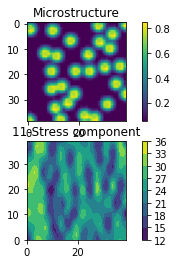

In [ ]:
# Stress field of the reduced image
stress(exp_code_img)


C11: 19.764760898787635

sigma: 
[[19.7648  0.1432  0.    ]
 [ 0.1432  7.7802  0.    ]
 [ 0.      0.      7.87  ]]

time: 12.036842823028564


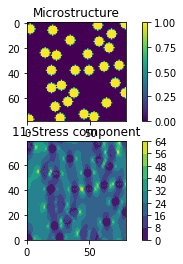

In [ ]:
# Stress field of the original image
stress(exp_original_img)

# Filters Plot

In [ ]:
# Plot the filters
# load the model
model = model
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

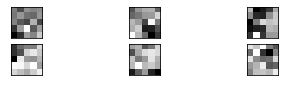

In [ ]:
from matplotlib import pyplot
# retrieve weights from the second hidden layer
filters, biases = encoder.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(1):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()